In [95]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tempfile
from matplotlib import pyplot as plt



batch_size = 100
img_height = 300
img_width = 300
data_dir ="plant_model"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 298 files belonging to 6 classes.
Using 239 files for training.
Found 298 files belonging to 6 classes.
Using 59 files for validation.


In [96]:
class_names = train_ds.class_names
print(class_names)

['Cactus', 'Coconut', 'Daisy', 'Hibiscus', 'Rambutan', 'Sunflower']


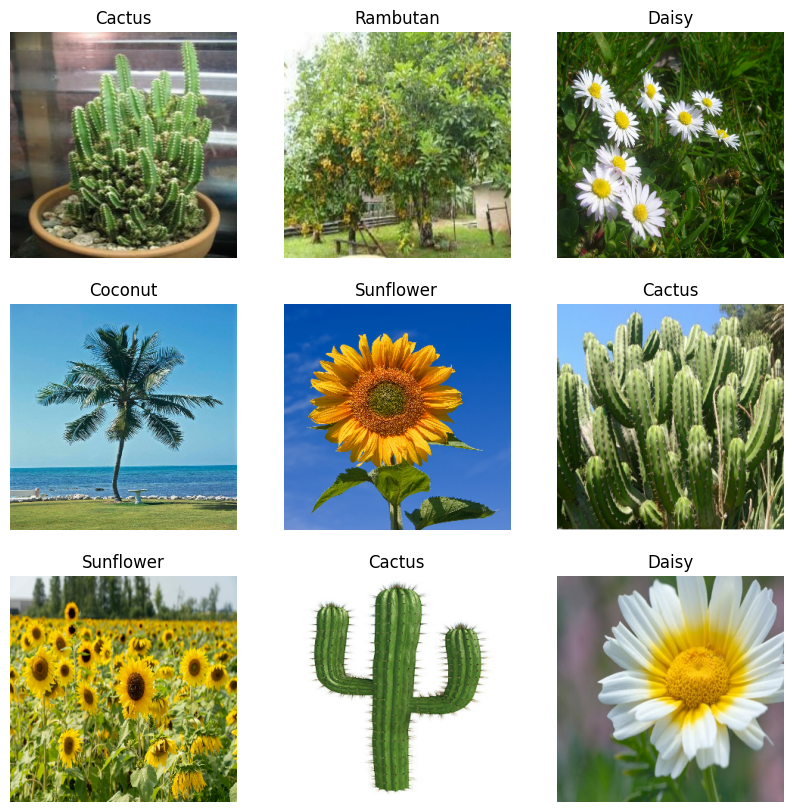

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [98]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 300, 300, 3)
(100,)


In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [100]:
num_classes = 6

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [101]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 64)      

In [103]:
epochs=20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

#Save the entire model as a SavedModel.
# !mkdir saved_model
model.save('saved_model/my_model')


Epoch 1/20
3/3 [==============================] - 10s 3s/step - loss: 5.2670 - accuracy: 0.2845 - val_loss: 3.9226 - val_accuracy: 0.1864
Epoch 2/20
3/3 [==============================] - 8s 2s/step - loss: 3.3592 - accuracy: 0.2971 - val_loss: 2.0447 - val_accuracy: 0.2712
Epoch 3/20
3/3 [==============================] - 8s 3s/step - loss: 1.9013 - accuracy: 0.2469 - val_loss: 1.6395 - val_accuracy: 0.3729
Epoch 4/20
3/3 [==============================] - 9s 3s/step - loss: 1.4701 - accuracy: 0.5356 - val_loss: 1.4353 - val_accuracy: 0.4407
Epoch 5/20
3/3 [==============================] - 9s 3s/step - loss: 1.1373 - accuracy: 0.6444 - val_loss: 1.2516 - val_accuracy: 0.4407
Epoch 6/20
3/3 [==============================] - 9s 3s/step - loss: 0.7933 - accuracy: 0.7113 - val_loss: 0.9793 - val_accuracy: 0.6271
Epoch 7/20
3/3 [==============================] - 9s 4s/step - loss: 0.5087 - accuracy: 0.8410 - val_loss: 0.9205 - val_accuracy: 0.6780
Epoch 8/20
3/3 [========================

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [104]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 64)      

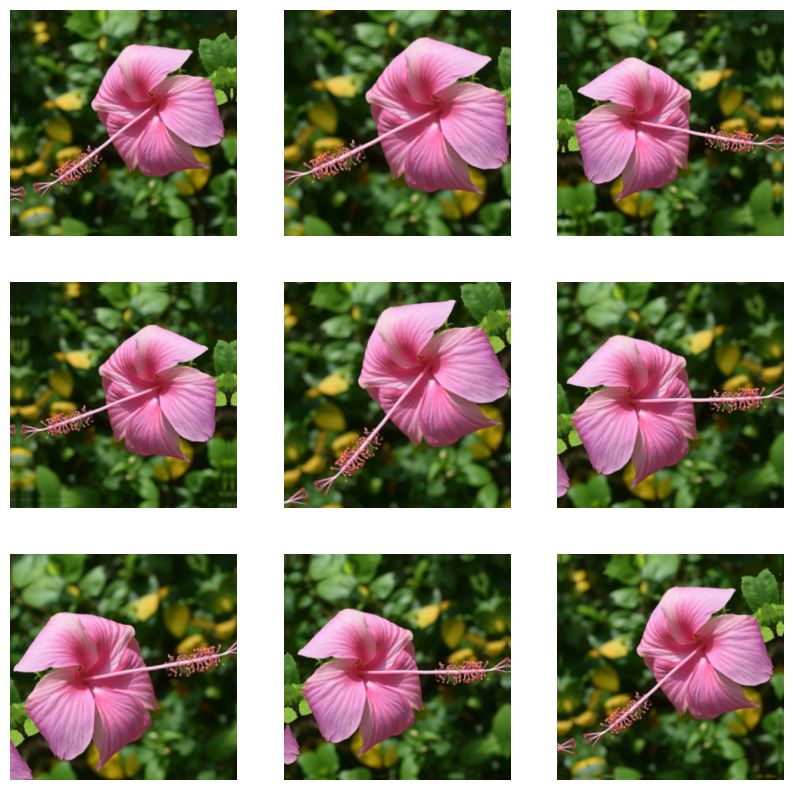

In [105]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [106]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 300, 300, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                

In [114]:



img = keras.preprocessing.image.load_img(
    "asset/tree37.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 48ms/step
This image most likely belongs to Rambutan with a 99.86 percent confidence.


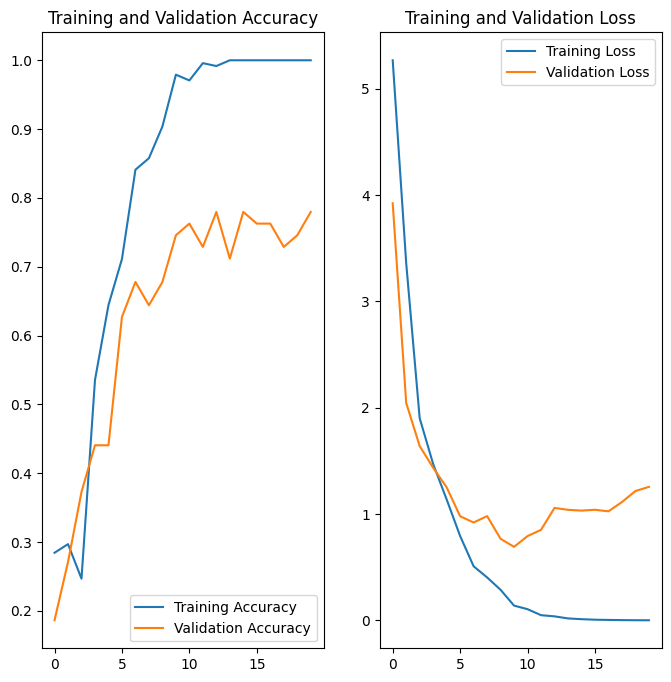

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()